Timestamps that *do not* change
* `created_at`
* `started_at` (can change if restarted)
* `closed_at`

Timestamps that change (would need to analyze `versions` to get activity starts and stops) 
* `updated_at`
* `assigned_at`
* `placed_on_hold_at`

[Timestamps set by status change](https://github.com/department-of-veterans-affairs/caseflow/blob/9b73d5ff8aa6a65be9a529b258bde91caa65de82/app/models/task.rb#L644)

See ["Task timestamps deep dive #12455"](https://github.com/department-of-veterans-affairs/caseflow/issues/12455) 

Run the following in a Rails Console to collect data. It should complete in a few minutes.
  * Note: There may be multiple completed task of same type for same appeal, [e.g., AttorneyTasks](https://dsva.slack.com/archives/CJL810329/p1592495076169500?thread_ts=1592494771.168200&cid=CJL810329).

```ruby
f = File.new('output.csv', 'w')
stats_arr=[]
task_types=[:HearingTask, :JudgeAssignTask, :AttorneyTask, :JudgeDecisionReviewTask, :AttorneyRewriteTask]
task_types.each{|task_type|
    tasks=Task.where(type: task_type).completed
    tasks.each{ |t|
      f.puts [t.type, t.id, t.appeal_id, t.parent_id,
       t.created_at.iso8601(9), 
       t.assigned_at.iso8601(9), 
       t.closed_at.iso8601(9),
       t.children.completed.map{|c| [c.type, c.id, c.created_at&.iso8601(9), c.assigned_at&.iso8601(9), c.closed_at&.iso8601(9)] }
       ].to_s
    }
}
f.close
```

In [101]:
import dateutil.parser
def parseTime(s): 
    return dateutil.parser.isoparse(s).replace(microsecond=0)


In [103]:
a=["HearingTask", 124329, 335689, 124328, 
   "2019-02-28T17:39:51.095057000Z", "2019-02-28T17:39:51.095057000Z", "2019-04-24T05:08:03.455777000Z", 
   [
       ["AssignHearingDispositionTask", 138590, "2019-03-11T14:19:23.590815000Z", "2019-03-11T14:19:23.590815000Z", "2019-04-24T05:08:03.448965000Z"], 
       ["ScheduleHearingTask", 124330, "2019-02-28T17:39:51.119222000Z", "2019-02-28T17:39:51.119222000Z", "2019-03-11T14:19:23.601147000Z"]
   ]
  ]
ttype, tid, aid, tpid = a[0:4]
creAt, assAt, cloAt = map(parseTime, a[4:7])
children=a[7]
rowdata={"ttype":ttype, "tid":tid, "aid":aid, "tpid":tpid, 
           "creAt":creAt, "assAt":assAt, "cloAt":cloAt}
rowdata, children

({'ttype': 'HearingTask',
  'tid': 124329,
  'aid': 335689,
  'tpid': 124328,
  'creAt': datetime.datetime(2019, 2, 28, 17, 39, 51, tzinfo=tzutc()),
  'assAt': datetime.datetime(2019, 2, 28, 17, 39, 51, tzinfo=tzutc()),
  'cloAt': datetime.datetime(2019, 4, 24, 5, 8, 3, tzinfo=tzutc())},
 [['AssignHearingDispositionTask',
   138590,
   '2019-03-11T14:19:23.590815000Z',
   '2019-03-11T14:19:23.590815000Z',
   '2019-04-24T05:08:03.448965000Z'],
  ['ScheduleHearingTask',
   124330,
   '2019-02-28T17:39:51.119222000Z',
   '2019-02-28T17:39:51.119222000Z',
   '2019-03-11T14:19:23.601147000Z']])

In [ ]:
import pandas as pd
import numpy as np

In [32]:
df = pd.DataFrame(columns=["ttype","tid", "aid", "tpid", "creAt", "assAt", "cloAt"])
# https://numpy.org/doc/stable/user/basics.types.html
#df = df.infer_objects()
df = df.astype({"ttype":str, "tid":np.uintc, "aid":np.uintc, "tpid":np.uintc, 
           #"creAt":creAt, "assAt":assAt, "cloAt":cloAt
               })
df.append(rowdata, ignore_index=True) 

,ttype,tid,aid,tpid,creAt,assAt,cloAt
0,HearingTask,124329,335689,124328,2019-02-28 17:39:51.095057+00:00,2019-02-28 17:39:51.095057+00:00,2019-04-24 05:08:03.455777+00:00


In [35]:
df.dtypes

ttype    object
tid      uint32
aid      uint32
tpid     uint32
creAt    object
assAt    object
cloAt    object
dtype: object

In [40]:
import sys
# https://jakevdp.github.io/blog/2017/12/05/installing-python-packages-from-jupyter/
!{sys.executable} -m pip install spans

In [ ]:
from datetime import timedelta
from spans import datetimerange, datetimerangeset, timedeltarange, timedeltarangeset

In [308]:
sorted_children=sorted(children, key=lambda c: c[1])
sorted_children

[['ScheduleHearingTask',
  663826,
  '2020-02-04T15:12:32.239737000Z',
  '2020-02-04T15:12:32.239737000Z',
  '2020-02-04T15:13:04.866419000Z'],
 ['AssignHearingDispositionTask',
  663828,
  '2020-02-04T15:13:04.754098000Z',
  '2020-02-04T15:13:04.754098000Z',
  '2020-02-06T05:12:15.530479000Z']]

In [309]:
def pp(rs):
    for i, r in enumerate(rs):
        print( f'{i}: ', r.upper-r.lower, "::", r.lower, "-", r.upper )
def sumTimeIn(rs):
    return sum(map(lambda r: r.upper-r.lower, rs), timedelta(microseconds=0))
        
    

In [313]:
print(creAt, cloAt)
r=datetimerange(creAt, cloAt)
print(cloAt - creAt, r)
orig_s=datetimerangeset([r])
s=orig_s.copy()
pp(s)
rowdata={}
for child in sorted_children:
    c_ttype=child[0]
    c_creAt, c_assAt, c_cloAt = map(parseTime, child[2:5])
    startAt=c_assAt
    print("  * ",c_ttype, c_cloAt - startAt, startAt, c_assAt, c_cloAt)
    c_s=datetimerangeset([datetimerange(startAt, c_cloAt)])
    contains = orig_s.contains(datetimerange(startAt, c_cloAt))
    s=s.difference(c_s)
    print("    - Curr set: ", contains, len(s))
    pp(s)
    if c_ttype in rowdata:
        raise RuntimeError(f'Task {tid}')
    rowdata[c_ttype]=c_cloAt - startAt
rowdata["UnaccountedTask"]=sumTimeIn(s).total_seconds()/60 # in minutes
rowdata

2020-02-04 15:12:32+00:00 2020-02-06 05:12:15+00:00
1 day, 13:59:43 datetimerange(datetime.datetime(2020, 2, 4, 15, 12, 32, tzinfo=tzutc()), datetime.datetime(2020, 2, 6, 5, 12, 15, tzinfo=tzutc()))
0:  1 day, 13:59:43 :: 2020-02-04 15:12:32+00:00 - 2020-02-06 05:12:15+00:00
  *  ScheduleHearingTask 0:00:32 2020-02-04 15:12:32+00:00 2020-02-04 15:12:32+00:00 2020-02-04 15:13:04+00:00
    - Curr set:  True 1
0:  1 day, 13:59:11 :: 2020-02-04 15:13:04+00:00 - 2020-02-06 05:12:15+00:00
  *  AssignHearingDispositionTask 1 day, 13:59:11 2020-02-04 15:13:04+00:00 2020-02-04 15:13:04+00:00 2020-02-06 05:12:15+00:00
    - Curr set:  True 0


{'ScheduleHearingTask': datetime.timedelta(seconds=32),
 'AssignHearingDispositionTask': datetime.timedelta(days=1, seconds=50351),
 'Unaccounted': 0.0}

In [154]:
pp(orig_s)
print("----")
pp(s)
rowdata

0:  16:39:53 :: 2020-05-18 21:24:25+00:00 - 2020-05-19 14:04:18+00:00
----
0:  16:39:53 :: 2020-05-18 21:24:25+00:00 - 2020-05-19 14:04:18+00:00


{'ttype': 'JudgeAssignTask',
 'tid': 902300,
 'aid': 17619,
 'tpid': 325218,
 'creAt': datetime.datetime(2020, 5, 18, 21, 24, 25, tzinfo=tzutc()),
 'assAt': datetime.datetime(2020, 5, 18, 21, 24, 25, tzinfo=tzutc()),
 'cloAt': datetime.datetime(2020, 5, 19, 14, 4, 18, tzinfo=tzutc()),
 'Unaccounted': datetime.timedelta(seconds=59993)}

In [244]:
# task_type="JudgeAssignTask"
baseFilename="prod-output-2020-06-22b"
infile = open(f'./{baseFilename}.csv', 'r')
lines = infile.readlines()
# df = pd.read_csv (f'./{baseFilename}.csv', sep="\t", header = 0, names=["ttype","tid", "aid", "tpid", "creAt", "assAt", "cloAt", "ch"])
# print (df)

In [350]:
import traceback
alldata=[]
keys=set()
for linenum, line in enumerate(lines, start=1):
    try:
        a=eval(line)
        ttype, tid, aid, tpid = a[0:4]
        creAt, assAt, cloAt = map(parseTime, a[4:7])
        children=a[7]
        rowdata={"ttype":ttype, "tid":tid, "aid":aid, "tpid":tpid, 
               "creAt":creAt, "assAt":assAt, "cloAt":cloAt}

        r=datetimerange(creAt, cloAt)
        orig_s=datetimerangeset([r])
        s=orig_s.copy()
        sorted_children=sorted(children, key=lambda c: c[1])
        for child in sorted_children:
            c_ttype=child[0]
            c_creAt, c_assAt, c_cloAt = map(parseTime, child[2:5])
            startAt=c_assAt
            c_s=datetimerangeset([datetimerange(startAt, c_cloAt)])
            contains = orig_s.contains(datetimerange(startAt, c_cloAt))
            s=s.difference(c_s)
            if c_ttype in rowdata:
                print(f'Multiple {c_ttype}: {ttype} {tid}, line {linenum}', file=sys.stderr)
                rowdata[c_ttype]+=(c_cloAt - startAt).total_seconds()/60
            else:
                rowdata[c_ttype]=(c_cloAt - startAt).total_seconds()/60
        rowdata["UnaccountedTask"]=sumTimeIn(s).total_seconds()/60 # in minutes
        keys.update(list(rowdata.keys()))
        alldata.append(rowdata)
    except Exception as e:
        print(f'Unexpected: {ttype} {tid} (appeal {aid}), line {linenum}', file=sys.stderr)
        print(e)
        traceback.print_exc()
list(keys)

Multiple ScheduleHearingTask: HearingTask 123462, line 8590
Multiple ScheduleHearingTask: HearingTask 123472, line 8595
Multiple ScheduleHearingTask: HearingTask 123727, line 8859
Multiple ScheduleHearingTask: HearingTask 123874, line 12473
Multiple ScheduleHearingTask: HearingTask 123894, line 12477
Multiple ScheduleHearingTask: HearingTask 123922, line 12491
Multiple IhpColocatedTask: JudgeAssignTask 257174, line 23088
Multiple OtherColocatedTask: JudgeAssignTask 447859, line 29750
Multiple TimedHoldTask: JudgeAssignTask 635343, line 31374
Multiple IhpColocatedTask: JudgeAssignTask 736870, line 31553
Multiple TimedHoldTask: JudgeAssignTask 529515, line 35833
Multiple TimedHoldTask: JudgeAssignTask 529515, line 35833
Multiple TimedHoldTask: JudgeAssignTask 529515, line 35833
Multiple IhpColocatedTask: AttorneyTask 1295, line 38974
Multiple IhpColocatedTask: AttorneyTask 1295, line 38974
Multiple IhpColocatedTask: AttorneyTask 1295, line 38974
Multiple IhpColocatedTask: AttorneyTask 12

Upper bound (2018-12-03 00:00:00+00:00) is less than lower bound (2020-05-06 13:46:25+00:00)


Multiple IhpColocatedTask: AttorneyTask 768924, line 53296
Multiple FoiaColocatedTask: AttorneyTask 673640, line 53593
Multiple FoiaColocatedTask: AttorneyTask 673640, line 53593
Multiple IhpColocatedTask: AttorneyTask 841573, line 54035
Multiple ScheduleHearingColocatedTask: AttorneyTask 219190, line 54264
Multiple ScheduleHearingColocatedTask: AttorneyTask 219190, line 54264
Multiple ScheduleHearingColocatedTask: AttorneyTask 219190, line 54264
Multiple AttorneyRewriteTask: JudgeDecisionReviewTask 506533, line 54493
Multiple AttorneyRewriteTask: JudgeDecisionReviewTask 506533, line 54493
Multiple AttorneyRewriteTask: JudgeDecisionReviewTask 24961, line 54515
Multiple AttorneyRewriteTask: JudgeDecisionReviewTask 502076, line 54817
Multiple AttorneyRewriteTask: JudgeDecisionReviewTask 753395, line 54940
Multiple AttorneyRewriteTask: JudgeDecisionReviewTask 137679, line 55020
Multiple AttorneyRewriteTask: JudgeDecisionReviewTask 262376, line 55157
Multiple AttorneyRewriteTask: JudgeDeci

Multiple AttorneyRewriteTask: JudgeDecisionReviewTask 705364, line 62778
Multiple AttorneyRewriteTask: JudgeDecisionReviewTask 740616, line 62805
Multiple AttorneyRewriteTask: JudgeDecisionReviewTask 664694, line 63051
Multiple AttorneyRewriteTask: JudgeDecisionReviewTask 741631, line 63109
Multiple AttorneyRewriteTask: JudgeDecisionReviewTask 676539, line 63145
Multiple AttorneyRewriteTask: JudgeDecisionReviewTask 776265, line 63274
Multiple AttorneyRewriteTask: JudgeDecisionReviewTask 783776, line 63364
Multiple AttorneyRewriteTask: JudgeDecisionReviewTask 730762, line 63441
Multiple AttorneyRewriteTask: JudgeDecisionReviewTask 758140, line 63549
Multiple AttorneyRewriteTask: JudgeDecisionReviewTask 835781, line 63646
Multiple AttorneyRewriteTask: JudgeDecisionReviewTask 627237, line 63702
Multiple AttorneyRewriteTask: JudgeDecisionReviewTask 759260, line 63704
Multiple AttorneyRewriteTask: JudgeDecisionReviewTask 784512, line 63778
Multiple AttorneyRewriteTask: JudgeDecisionReviewTa

Upper bound (2018-12-03 00:00:00+00:00) is less than lower bound (2020-05-06 13:41:34+00:00)
Upper bound (2018-10-17 00:00:00+00:00) is less than lower bound (2020-05-06 13:38:32+00:00)


Multiple AttorneyRewriteTask: JudgeDecisionReviewTask 881806, line 67823
Multiple AttorneyRewriteTask: JudgeDecisionReviewTask 907971, line 68225
Multiple AttorneyRewriteTask: JudgeDecisionReviewTask 907971, line 68225
Multiple AttorneyRewriteTask: JudgeDecisionReviewTask 887423, line 68251
Multiple AttorneyRewriteTask: JudgeDecisionReviewTask 887977, line 68285
Multiple AttorneyRewriteTask: JudgeDecisionReviewTask 919914, line 68376
Multiple AttorneyRewriteTask: JudgeDecisionReviewTask 929947, line 68624
Multiple AttorneyRewriteTask: JudgeDecisionReviewTask 930151, line 68633
Multiple AttorneyRewriteTask: JudgeDecisionReviewTask 916508, line 68978
Multiple AttorneyRewriteTask: JudgeDecisionReviewTask 719179, line 69038
Multiple AttorneyRewriteTask: JudgeDecisionReviewTask 543894, line 69079
Multiple IhpColocatedTask: AttorneyRewriteTask 594778, line 70051
Multiple OtherColocatedTask: AttorneyRewriteTask 459432, line 70143
Multiple PoaClarificationColocatedTask: AttorneyRewriteTask 554

['FoiaColocatedTask',
 'PreRoutingFoiaColocatedTask',
 'TranslationTask',
 'ChangeHearingDispositionTask',
 'AttorneyRewriteTask',
 'IhpColocatedTask',
 'ExtensionColocatedTask',
 'PreRoutingMissingHearingTranscriptsColocatedTask',
 'aid',
 'RetiredVljColocatedTask',
 'creAt',
 'UnaccountedTask',
 'PendingScanningVbmsColocatedTask',
 'assAt',
 'TimedHoldTask',
 'EvidenceSubmissionWindowTask',
 'PreRoutingTranslationColocatedTask',
 'tid',
 'MissingRecordsColocatedTask',
 'HearingClarificationColocatedTask',
 'NewRepArgumentsColocatedTask',
 'ScheduleHearingColocatedTask',
 'AttorneyTask',
 'AddressVerificationColocatedTask',
 'ScheduleHearingTask',
 'StayedAppealColocatedTask',
 'TranslationColocatedTask',
 'ttype',
 'tpid',
 'MissingHearingTranscriptsColocatedTask',
 'UnaccreditedRepColocatedTask',
 'cloAt',
 'PoaClarificationColocatedTask',
 'OtherColocatedTask',
 'AojColocatedTask',
 'AssignHearingDispositionTask']

In [314]:
infile.close()

In [351]:
len(keys)

36

# df = pd.DataFrame(columns=["ttype","tid", "aid", "tpid", "creAt", "assAt", "cloAt"])
df = pd.DataFrame(columns=list(keys))
# https://numpy.org/doc/stable/user/basics.types.html
#df = df.infer_objects()
df = df.astype({"ttype":str, "tid":np.uintc, "aid":np.uintc, "tpid":np.uintc, 
           #"creAt":creAt, "assAt":assAt, "cloAt":cloAt
               })

In [352]:
df=pd.DataFrame(alldata)

In [353]:
len(alldata)

71010

In [354]:
df.count()

ttype                                               71010
tid                                                 71010
aid                                                 71010
tpid                                                71010
creAt                                               71010
assAt                                               71010
cloAt                                               71010
ScheduleHearingTask                                 19041
AssignHearingDispositionTask                        19719
UnaccountedTask                                     71010
ChangeHearingDispositionTask                          514
EvidenceSubmissionWindowTask                          187
OtherColocatedTask                                    276
PreRoutingFoiaColocatedTask                            20
StayedAppealColocatedTask                              47
IhpColocatedTask                                      469
FoiaColocatedTask                                     106
ScheduleHearin

In [355]:
alldata[0:2]

[{'ttype': 'HearingTask',
  'tid': 124329,
  'aid': 335689,
  'tpid': 124328,
  'creAt': datetime.datetime(2019, 2, 28, 17, 39, 51, tzinfo=tzutc()),
  'assAt': datetime.datetime(2019, 2, 28, 17, 39, 51, tzinfo=tzutc()),
  'cloAt': datetime.datetime(2019, 4, 24, 5, 8, 3, tzinfo=tzutc()),
  'ScheduleHearingTask': 15639.533333333333,
  'AssignHearingDispositionTask': 62808.666666666664,
  'UnaccountedTask': 0.0},
 {'ttype': 'HearingTask',
  'tid': 124348,
  'aid': 166529,
  'tpid': 124347,
  'creAt': datetime.datetime(2019, 2, 28, 17, 39, 55, tzinfo=tzutc()),
  'assAt': datetime.datetime(2019, 2, 28, 17, 39, 55, tzinfo=tzutc()),
  'cloAt': datetime.datetime(2019, 7, 27, 5, 5, 35, tzinfo=tzutc()),
  'ScheduleHearingTask': 109187.61666666667,
  'AssignHearingDispositionTask': 104618.05,
  'UnaccountedTask': 0.0}]

In [356]:
df[0:2]

,ttype,tid,aid,tpid,creAt,assAt,cloAt,ScheduleHearingTask,AssignHearingDispositionTask,UnaccountedTask,...,NewRepArgumentsColocatedTask,TranslationTask,PreRoutingTranslationColocatedTask,AojColocatedTask,PendingScanningVbmsColocatedTask,PreRoutingMissingHearingTranscriptsColocatedTask,UnaccreditedRepColocatedTask,RetiredVljColocatedTask,AttorneyTask,AttorneyRewriteTask
0,HearingTask,124329,335689,124328,2019-02-28 17:39:51+00:00,2019-02-28 17:39:51+00:00,2019-04-24 05:08:03+00:00,15639.533333,62808.666667,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,HearingTask,124348,166529,124347,2019-02-28 17:39:55+00:00,2019-02-28 17:39:55+00:00,2019-07-27 05:05:35+00:00,109187.616667,104618.050000,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [357]:
df[df['UnaccountedTask']>1]

,ttype,tid,aid,tpid,creAt,assAt,cloAt,ScheduleHearingTask,AssignHearingDispositionTask,UnaccountedTask,...,NewRepArgumentsColocatedTask,TranslationTask,PreRoutingTranslationColocatedTask,AojColocatedTask,PendingScanningVbmsColocatedTask,PreRoutingMissingHearingTranscriptsColocatedTask,UnaccreditedRepColocatedTask,RetiredVljColocatedTask,AttorneyTask,AttorneyRewriteTask
13,HearingTask,112005,8168,112004,2019-02-26 20:00:36+00:00,2019-02-26 20:00:36+00:00,2019-12-06 05:07:11+00:00,91112.100000,41193.850000,274320.633333,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20,HearingTask,112068,34926,112067,2019-02-26 20:00:53+00:00,2019-02-26 20:00:53+00:00,2019-12-15 05:01:04+00:00,69489.883333,75805.816667,274284.483333,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
39,HearingTask,83237,13774,83236,2019-02-21 21:00:51+00:00,2019-02-21 21:00:51+00:00,2019-11-07 05:05:27+00:00,61707.616667,71222.650000,239074.333333,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
51,HearingTask,83340,28190,83339,2019-02-21 21:01:18+00:00,2019-02-21 21:01:18+00:00,2020-04-17 05:01:21+00:00,49605.316667,72783.516667,482891.216667,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
54,HearingTask,83367,31742,83366,2019-02-21 21:01:25+00:00,2019-02-21 21:01:25+00:00,2019-11-24 05:02:19+00:00,51563.166667,105843.966667,239073.766667,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71005,AttorneyRewriteTask,950178,32136,799539,2020-06-12 11:22:02+00:00,2020-06-12 11:22:02+00:00,2020-06-12 15:22:38+00:00,NaN,NaN,240.600000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
71006,AttorneyRewriteTask,949907,25644,939696,2020-06-11 23:33:05+00:00,2020-06-11 23:33:05+00:00,2020-06-15 13:39:48+00:00,NaN,NaN,5166.716667,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
71007,AttorneyRewriteTask,950528,24987,902689,2020-06-12 13:26:22+00:00,2020-06-12 13:26:22+00:00,2020-06-12 13:45:58+00:00,NaN,NaN,19.600000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
71008,AttorneyRewriteTask,966691,75837,921425,2020-06-19 19:32:59+00:00,2020-06-19 19:32:59+00:00,2020-06-19 21:57:24+00:00,NaN,NaN,144.416667,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [358]:
df[df['UnaccountedTask']>1].groupby(['ttype']).count()

,tid,aid,tpid,creAt,assAt,cloAt,ScheduleHearingTask,AssignHearingDispositionTask,UnaccountedTask,ChangeHearingDispositionTask,...,NewRepArgumentsColocatedTask,TranslationTask,PreRoutingTranslationColocatedTask,AojColocatedTask,PendingScanningVbmsColocatedTask,PreRoutingMissingHearingTranscriptsColocatedTask,UnaccreditedRepColocatedTask,RetiredVljColocatedTask,AttorneyTask,AttorneyRewriteTask
ttype,,,,,,,,,,,,,,,,,,,,,
AttorneyRewriteTask,1887,1887,1887,1887,1887,1887,0,0,1887,0,...,1,0,0,0,0,0,0,0,0,0
AttorneyTask,15447,15447,15447,15447,15447,15447,0,0,15447,0,...,4,2,4,7,1,1,2,1,0,0
HearingTask,3258,3258,3258,3258,3258,3258,2353,2367,3258,77,...,0,0,0,0,0,0,0,0,0,0
JudgeAssignTask,17684,17684,17684,17684,17684,17684,0,0,17684,0,...,0,0,0,0,0,0,0,0,0,0
JudgeDecisionReviewTask,14813,14813,14813,14813,14813,14813,0,0,14813,0,...,0,0,0,0,0,0,0,0,14813,1601


In [359]:
df.groupby(['ttype']).count()

,tid,aid,tpid,creAt,assAt,cloAt,ScheduleHearingTask,AssignHearingDispositionTask,UnaccountedTask,ChangeHearingDispositionTask,...,NewRepArgumentsColocatedTask,TranslationTask,PreRoutingTranslationColocatedTask,AojColocatedTask,PendingScanningVbmsColocatedTask,PreRoutingMissingHearingTranscriptsColocatedTask,UnaccreditedRepColocatedTask,RetiredVljColocatedTask,AttorneyTask,AttorneyRewriteTask
ttype,,,,,,,,,,,,,,,,,,,,,
AttorneyRewriteTask,1893,1893,1893,1893,1893,1893,0,0,1893,0,...,1,0,0,0,0,0,0,0,0,0
AttorneyTask,15447,15447,15447,15447,15447,15447,0,0,15447,0,...,4,2,4,7,1,1,2,1,0,0
HearingTask,21118,21118,21118,21118,21118,21118,19041,19719,21118,514,...,0,0,0,0,0,0,0,0,0,0
JudgeAssignTask,17736,17736,17736,17736,17736,17736,0,0,17736,0,...,0,0,0,0,0,0,0,0,0,0
JudgeDecisionReviewTask,14816,14816,14816,14816,14816,14816,0,0,14816,0,...,0,0,0,0,0,0,0,0,14816,1601


In [360]:
print(df.groupby(['ttype']).count().to_csv())

ttype,tid,aid,tpid,creAt,assAt,cloAt,ScheduleHearingTask,AssignHearingDispositionTask,UnaccountedTask,ChangeHearingDispositionTask,EvidenceSubmissionWindowTask,OtherColocatedTask,PreRoutingFoiaColocatedTask,StayedAppealColocatedTask,IhpColocatedTask,FoiaColocatedTask,ScheduleHearingColocatedTask,TranslationColocatedTask,PoaClarificationColocatedTask,TimedHoldTask,MissingHearingTranscriptsColocatedTask,ExtensionColocatedTask,HearingClarificationColocatedTask,MissingRecordsColocatedTask,AddressVerificationColocatedTask,NewRepArgumentsColocatedTask,TranslationTask,PreRoutingTranslationColocatedTask,AojColocatedTask,PendingScanningVbmsColocatedTask,PreRoutingMissingHearingTranscriptsColocatedTask,UnaccreditedRepColocatedTask,RetiredVljColocatedTask,AttorneyTask,AttorneyRewriteTask
AttorneyRewriteTask,1893,1893,1893,1893,1893,1893,0,0,1893,0,0,16,0,5,35,7,0,0,3,0,1,1,0,1,0,1,0,0,0,0,0,0,0,0,0
AttorneyTask,15447,15447,15447,15447,15447,15447,0,0,15447,0,1,219,18,33,350,92,9,18,53,0,4,46,21,4

criteria=True
for taskCols in list(filter(lambda c: c.endswith("Task"), list(df.columns))):
    criteria|=(not df[taskCols].isnull() | df[taskCols]>0)
df.loc[criteria]

In [362]:
df[df['ttype']=='HearingTask']

,ttype,tid,aid,tpid,creAt,assAt,cloAt,ScheduleHearingTask,AssignHearingDispositionTask,UnaccountedTask,...,NewRepArgumentsColocatedTask,TranslationTask,PreRoutingTranslationColocatedTask,AojColocatedTask,PendingScanningVbmsColocatedTask,PreRoutingMissingHearingTranscriptsColocatedTask,UnaccreditedRepColocatedTask,RetiredVljColocatedTask,AttorneyTask,AttorneyRewriteTask
0,HearingTask,124329,335689,124328,2019-02-28 17:39:51+00:00,2019-02-28 17:39:51+00:00,2019-04-24 05:08:03+00:00,15639.533333,62808.666667,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,HearingTask,124348,166529,124347,2019-02-28 17:39:55+00:00,2019-02-28 17:39:55+00:00,2019-07-27 05:05:35+00:00,109187.616667,104618.050000,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,HearingTask,124363,136865,124362,2019-02-28 17:39:59+00:00,2019-02-28 17:39:59+00:00,2019-04-06 05:01:02+00:00,20037.000000,32484.016667,0.033333,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,HearingTask,249326,225648,233713,2019-06-25 21:09:17+00:00,2019-06-25 21:09:17+00:00,2019-08-03 05:01:10+00:00,845.183333,54346.700000,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,HearingTask,124387,141988,124386,2019-02-28 17:40:06+00:00,2019-02-28 17:40:06+00:00,2019-05-10 05:04:05+00:00,44817.733333,56666.250000,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21113,HearingTask,910954,878294,670793,2020-05-22 11:42:51+00:00,2020-05-22 11:42:51+00:00,2020-06-12 05:08:26+00:00,NaN,29845.566667,0.016667,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
21114,HearingTask,950841,66342,944490,2020-06-12 15:00:27+00:00,2020-06-12 15:00:27+00:00,2020-06-17 05:00:55+00:00,45.200000,6555.266667,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
21115,HearingTask,950852,817560,950851,2020-06-12 15:00:29+00:00,2020-06-12 15:00:29+00:00,2020-06-19 05:00:43+00:00,31.883333,9448.350000,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
21116,HearingTask,950839,207089,950838,2020-06-12 15:00:26+00:00,2020-06-12 15:00:26+00:00,2020-06-19 05:09:41+00:00,31.066667,9458.183333,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [363]:
(df[df['ttype']=='HearingTask'].notna()).any(axis=0)

ttype                                                True
tid                                                  True
aid                                                  True
tpid                                                 True
creAt                                                True
assAt                                                True
cloAt                                                True
ScheduleHearingTask                                  True
AssignHearingDispositionTask                         True
UnaccountedTask                                      True
ChangeHearingDispositionTask                         True
EvidenceSubmissionWindowTask                         True
OtherColocatedTask                                  False
PreRoutingFoiaColocatedTask                         False
StayedAppealColocatedTask                           False
IhpColocatedTask                                    False
FoiaColocatedTask                                   False
ScheduleHearin

In [364]:
# Filter out columns that do not contain values
# https://stackoverflow.com/questions/35996768/filter-out-rows-columns-with-zero-values-in-multiindex-dataframe
subselectDf=df[df['ttype']=='HearingTask']
subDf=subselectDf.loc[:, (subselectDf.notna()).any(axis=0)]

In [365]:
taskCols=list(filter(lambda c: c.endswith("Task"), list(subDf.columns)))
taskCols

['ScheduleHearingTask',
 'AssignHearingDispositionTask',
 'UnaccountedTask',
 'ChangeHearingDispositionTask',
 'EvidenceSubmissionWindowTask']

In [390]:
from IPython.display import display

statsCols=['mean', 'median', 'min', 'max', 'std', 'var']

print(subDf.count())

dfDict={}
csvs=[]
for taskCol in taskCols:
    x=subDf[taskCol]
    print(taskCol, x.count())
    remove_outliers=subDf[x.between(x.quantile(.15), x.quantile(.85))]
    remove_zeros=remove_outliers[remove_outliers[taskCol]>=10]
    print(taskCol, "without outliers\n", remove_zeros.count())
    dfDict[taskCol]=remove_zeros
    stats=remove_zeros.groupby(['ttype']).agg({'ttype':'count', taskCol:statsCols})
    csvs.append(stats.to_csv())
    display(stats)
    
# grouped=remove_zeros.groupby(['doctype'])

ttype                           21118
tid                             21118
aid                             21118
tpid                            21118
creAt                           21118
assAt                           21118
cloAt                           21118
ScheduleHearingTask             19041
AssignHearingDispositionTask    19719
UnaccountedTask                 21118
ChangeHearingDispositionTask      514
EvidenceSubmissionWindowTask      186
dtype: int64
ScheduleHearingTask 19041
ScheduleHearingTask without outliers
 ttype                           13329
tid                             13329
aid                             13329
tpid                            13329
creAt                           13329
assAt                           13329
cloAt                           13329
ScheduleHearingTask             13329
AssignHearingDispositionTask    13321
UnaccountedTask                 13329
ChangeHearingDispositionTask      277
EvidenceSubmissionWindowTask        0
dtype: int6

ttype ScheduleHearingTask                              \
             count                mean        median           min   
ttype                                                                
HearingTask  13329        95105.726661  76339.583333  11235.583333   

                                                        
                       max           std           var  
ttype                                                   
HearingTask  280128.366667  68463.448774  4.687244e+09

AssignHearingDispositionTask 19719
AssignHearingDispositionTask without outliers
 ttype                           13803
tid                             13803
aid                             13803
tpid                            13803
creAt                           13803
assAt                           13803
cloAt                           13803
ScheduleHearingTask             13158
AssignHearingDispositionTask    13803
UnaccountedTask                 13803
ChangeHearingDispositionTask      347
EvidenceSubmissionWindowTask        0
dtype: int64


ttype AssignHearingDispositionTask                          \
             count                         mean    median           min   
ttype                                                                     
HearingTask  13803                 82798.049464  76877.45  52339.333333   

                                                   
                   max          std           var  
ttype                                              
HearingTask  140392.95  22548.01283  5.084129e+08

UnaccountedTask 21118
UnaccountedTask without outliers
 ttype                           3
tid                             3
aid                             3
tpid                            3
creAt                           3
assAt                           3
cloAt                           3
ScheduleHearingTask             1
AssignHearingDispositionTask    1
UnaccountedTask                 3
ChangeHearingDispositionTask    0
EvidenceSubmissionWindowTask    0
dtype: int64


ttype UnaccountedTask                                             \
            count            mean     median        min        max       std   
ttype                                                                          
HearingTask     3            11.0  11.266667  10.316667  11.416667  0.596518   

                       
                  var  
ttype                  
HearingTask  0.355833

ChangeHearingDispositionTask 514
ChangeHearingDispositionTask without outliers
 ttype                           176
tid                             176
aid                             176
tpid                            176
creAt                           176
assAt                           176
cloAt                           176
ScheduleHearingTask             171
AssignHearingDispositionTask    175
UnaccountedTask                 176
ChangeHearingDispositionTask    176
EvidenceSubmissionWindowTask      0
dtype: int64


ttype ChangeHearingDispositionTask                      \
            count                         mean   median        min   
ttype                                                                
HearingTask   176                 23293.825568  19237.5  16.866667   

                                                       
                      max           std           var  
ttype                                                  
HearingTask  62168.483333  17740.977145  3.147423e+08

EvidenceSubmissionWindowTask 186
EvidenceSubmissionWindowTask without outliers
 ttype                           130
tid                             130
aid                             130
tpid                            130
creAt                           130
assAt                           130
cloAt                           130
ScheduleHearingTask               0
AssignHearingDispositionTask      0
UnaccountedTask                 130
ChangeHearingDispositionTask      0
EvidenceSubmissionWindowTask    130
dtype: int64


ttype EvidenceSubmissionWindowTask                      \
            count                         mean      median     min   
ttype                                                                
HearingTask   130                 13758.017564  235.008333  193.95   

                                                       
                      max           std           var  
ttype                                                  
HearingTask  86977.916667  25800.440027  6.656627e+08

In [373]:
print("\n".join(csvs))

,ttype,ScheduleHearingTask,ScheduleHearingTask,ScheduleHearingTask,ScheduleHearingTask,ScheduleHearingTask,ScheduleHearingTask
,count,mean,median,min,max,std,var
ttype,,,,,,,
HearingTask,13329,95105.72666116466,76339.58333333333,11235.583333333334,280128.36666666664,68463.4487737521,4687243817.996177

,ttype,AssignHearingDispositionTask,AssignHearingDispositionTask,AssignHearingDispositionTask,AssignHearingDispositionTask,AssignHearingDispositionTask,AssignHearingDispositionTask
,count,mean,median,min,max,std,var
ttype,,,,,,,
HearingTask,13803,82798.04946388432,76877.45,52339.333333333336,140392.95,22548.01282972159,508412882.56928945

,ttype,UnaccountedTask,UnaccountedTask,UnaccountedTask,UnaccountedTask,UnaccountedTask,UnaccountedTask
,count,mean,median,min,max,std,var
ttype,,,,,,,
HearingTask,3,11.0,11.266666666666667,10.316666666666666,11.416666666666666,0.5965176722724428,0.35583333333333345

,ttype,ChangeHearingDispositionTask,ChangeHearingDispositionTask,ChangeHearingDisposition

In [391]:
df3=dfDict['ChangeHearingDispositionTask']
df3['ChangeHearingDispositionTask2']=df3['ChangeHearingDispositionTask']/60
df3

,ttype,tid,aid,tpid,creAt,assAt,cloAt,ScheduleHearingTask,AssignHearingDispositionTask,UnaccountedTask,ChangeHearingDispositionTask,EvidenceSubmissionWindowTask,ChangeHearingDispositionTask2
289,HearingTask,84814,76651,84813,2019-02-21 23:00:46+00:00,2019-02-21 23:00:46+00:00,2019-05-22 17:54:25+00:00,19823.450000,59741.650000,0.000000,49728.550000,NaN,828.809167
346,HearingTask,85214,615125,85213,2019-02-22 13:01:01+00:00,2019-02-22 13:01:01+00:00,2020-05-21 20:29:50+00:00,540346.983333,92775.883333,0.000000,21085.950000,NaN,351.432500
508,HearingTask,86376,43224,86375,2019-02-22 15:02:13+00:00,2019-02-22 15:02:13+00:00,2020-01-03 20:50:53+00:00,339971.516667,97189.633333,0.000000,16787.516667,NaN,279.791944
702,HearingTask,36452,260776,36451,2019-02-13 15:50:55+00:00,2019-02-13 15:50:55+00:00,2019-05-22 18:27:16+00:00,49187.166667,52404.066667,0.000000,39685.116667,NaN,661.418611
749,HearingTask,36774,594499,36773,2019-02-13 15:52:17+00:00,2019-02-13 15:52:17+00:00,2019-05-17 14:50:35+00:00,20449.383333,69621.716667,0.000000,43787.200000,NaN,729.786667
...,...,...,...,...,...,...,...,...,...,...,...,...,...
20881,HearingTask,749297,143184,749296,2020-03-10 20:00:34+00:00,2020-03-10 20:00:34+00:00,2020-05-21 20:28:54+00:00,1367.250000,65413.733333,0.000000,36927.350000,NaN,615.455833
20883,HearingTask,111126,80765,111125,2019-02-26 18:56:24+00:00,2019-02-26 18:56:24+00:00,2020-05-21 20:37:59+00:00,99488.083333,192102.716667,328215.183333,28295.600000,NaN,471.593333
20884,HearingTask,432018,22113,432017,2019-09-25 18:00:29+00:00,2019-09-25 18:00:29+00:00,2020-05-21 20:07:47+00:00,6491.666667,124666.900000,171903.533333,41225.200000,NaN,687.086667
20885,HearingTask,887514,496463,827989,2020-05-11 13:00:21+00:00,2020-05-11 13:00:21+00:00,2020-05-21 20:54:40+00:00,3.750000,13929.566667,0.000000,941.016667,NaN,15.683611


[[<matplotlib.axes._subplots.AxesSubplot object at 0x7f71d8f49b90>]]
AxesSubplot(0.125,0.125;0.775x0.755)
[[<matplotlib.axes._subplots.AxesSubplot object at 0x7f71d9006e90>]]
AxesSubplot(0.125,0.125;0.775x0.755)
[[<matplotlib.axes._subplots.AxesSubplot object at 0x7f71d8adbd10>]]
AxesSubplot(0.125,0.125;0.775x0.755)
[[<matplotlib.axes._subplots.AxesSubplot object at 0x7f71d9362a90>]]
AxesSubplot(0.125,0.125;0.775x0.755)
[[<matplotlib.axes._subplots.AxesSubplot object at 0x7f71d8f50410>]]
AxesSubplot(0.125,0.125;0.775x0.755)


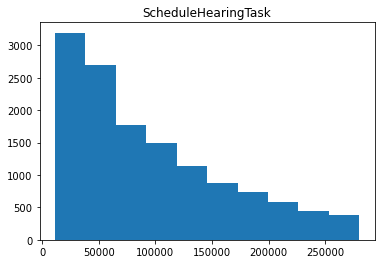

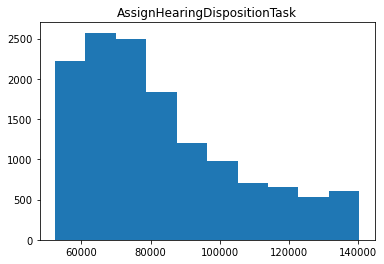

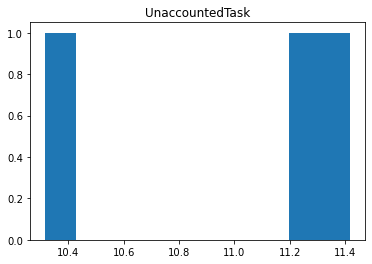

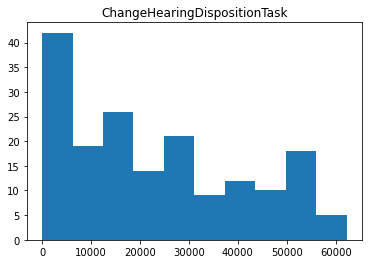

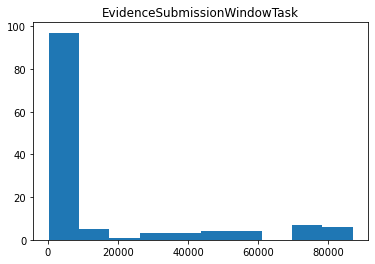

In [458]:
import matplotlib.pyplot as plt
def toMinutes1(vals):
#     return map(lambda x: x/60, vals)
    return vals/600
def toSeconds1(vals):
#     return map(lambda x: x*60, vals)
    return vals*600

toMinutes=lambda x: x/6000
toSeconds=lambda x: x*6000

for key,df in dfDict.items():
    axHist=df.hist(column=key, bins=10, grid=False) # calls matplotlib.pyplot.hist()
    print(axHist) # [[<matplotlib.axes._subplots.AxesSubplot object at 0x7f71d91ff290>]]
    axs=axHist[0] 
    print(axs) # [<matplotlib.axes._subplots.AxesSubplot object at 0x7f71d8fbd910>]
    for ax in axs:
        print(ax) # AxesSubplot(0.125,0.125;0.775x0.755); created by pd.Series.plot()
        # https://stackoverflow.com/questions/26198260/how-can-i-exponentially-scale-the-y-axis-with-matplotlib
        ax.set_xscale('function', functions=(toMinutes, toSeconds))
#         ax.set_xscale('log')

#         ax.set_yscale('log')
#         ax.set_xlabel("Task Duration (Seconds)", size=12)
        
# plt.show()

AxesSubplot(0.125,0.758226;0.775x0.121774)
AxesSubplot(0.125,0.599919;0.775x0.121774)
AxesSubplot(0.125,0.441613;0.775x0.121774)
AxesSubplot(0.125,0.283306;0.775x0.121774)
AxesSubplot(0.125,0.125;0.775x0.121774)


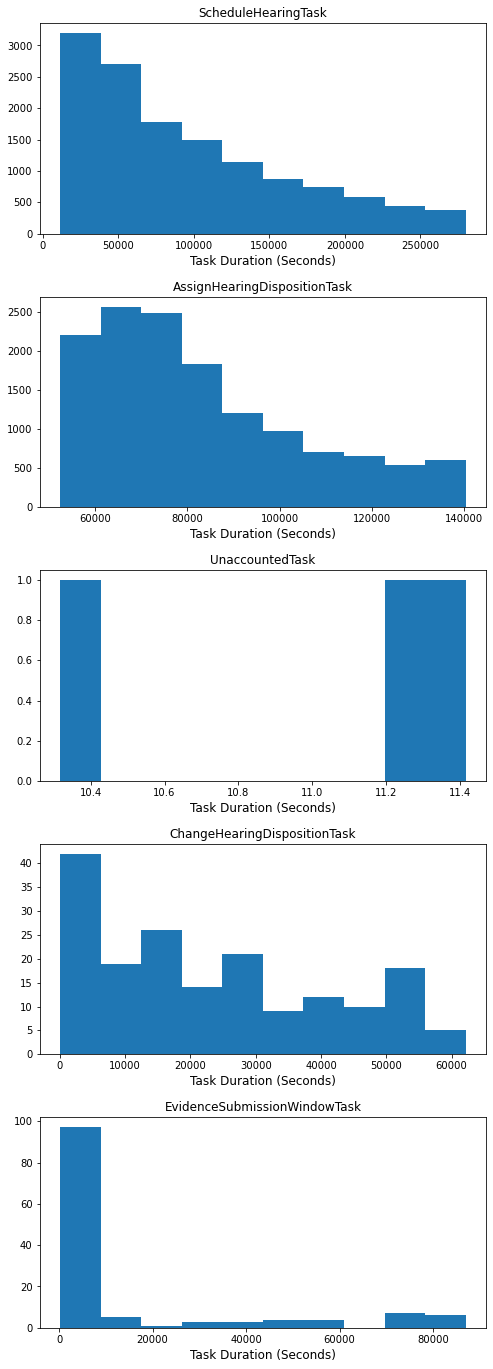

In [494]:
import matplotlib as mpl
mpl.rcParams['figure.autolayout'] = False 

import matplotlib.pyplot as plt
fig, axes = plt.subplots(num="HearingTask", nrows=5, ncols=1, sharex=False, figsize=(8,24))

exp = lambda x: x/100
log = lambda x: x*100

count=0
for key,df in dfDict.items():
    ax=axes[count]
    count+=1

    axHist = df.hist(ax=ax, column=key, bins=10, grid=False) # calls matplotlib.pyplot.hist()
    print(ax) # AxesSubplot(0.125,0.125;0.775x0.755); created by pd.Series.plot()
    # https://stackoverflow.com/questions/26198260/how-can-i-exponentially-scale-the-y-axis-with-matplotlib
#     ax.set_xscale('function', functions=(toMinutes, toSeconds))
    ax.set_xscale('function', functions=(exp, log))
#         ax.set_xscale('log')
    ax.set_xlabel("Task Duration (Seconds)", size=12)

# fig.subplots_adjust(top=0.9, bottom = 0.1)
plt.show()

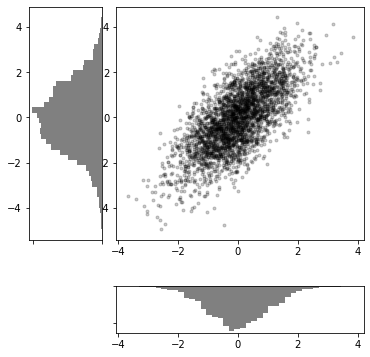

In [488]:
mean = [0, 0]
cov = [[1, 1], [1, 2]]
x, y = np.random.multivariate_normal(mean, cov, 3000).T

# Set up the axes with gridspec
fig = plt.figure(figsize=(6, 6))
grid = plt.GridSpec(4, 4, hspace=1, wspace=0.2)
main_ax = fig.add_subplot(grid[:-1, 1:])
y_hist = fig.add_subplot(grid[:-1, 0], xticklabels=[], sharey=main_ax)
x_hist = fig.add_subplot(grid[-1, 1:], yticklabels=[], sharex=main_ax)

# scatter points on the main axes
main_ax.plot(x, y, 'ok', markersize=3, alpha=0.2)

# histogram on the attached axes
x_hist.hist(x, 40, histtype='stepfilled',
            orientation='vertical', color='gray')
x_hist.invert_yaxis()

y_hist.hist(y, 40, histtype='stepfilled',
            orientation='horizontal', color='gray')
y_hist.invert_xaxis()

In [484]:
import matplotlib.pyplot as plt
hist,bin_edges = np.histogram(df3['ChangeHearingDispositionTask2'])
hist

array([42, 19, 26, 14, 21,  9, 12, 10, 18,  5])

In [403]:
def toMinutes(vals):
    return map(lambda x: x/60, vals)
list(toMinutes([120, 30]))

[2.0, 0.5]

In [411]:
toSec = lambda x: 6*x
toSec(120)

720

In [437]:
toMinutes(120)

0.2

In [ ]:
https://stackoverflow.com/questions/21033720/python-pandas-histogram-log-scale
import numpy as np
import matplotlib.pyplot as plt
import pandas
series = pandas.Series(np.random.normal(size=2000))
fig, ax = plt.subplots()
series.hist(ax=ax, bins=100, bottom=0.1)
ax.set_yscale('log')